In [2]:
import clean_datasets as mydata


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [3]:
bc = mydata.load_data(mydata.BREAST_COLS, mydata.BREAST_CANCER_NAME)
pipeline = mydata.get_breast_cancer_pipeline()

data/breast-cancer-wisconsin.csv


In [4]:
label_binalizer = LabelBinarizer()
X = pipeline.fit_transform(bc)
y = label_binalizer.fit_transform(bc['Class'])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train_set = X[train_index], y[train_index]
    strat_test_set = X[test_index], y[test_index]

In [6]:
Xtr, Ytr = strat_train_set
Xts, Yts = strat_test_set

In [6]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = DecisionTreeClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": range(1, 20, 2),
              "max_features": range(1, 9, 1),
              "min_samples_split": range(2, 20, 2),
              "criterion": ["gini", "entropy"]
             }

# run grid search
decision_tree_grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False, return_train_score=True)
start = time()
decision_tree_grid_search.fit(Xtr, Ytr)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(decision_tree_grid_search.cv_results_['params'])))
report(decision_tree_grid_search.cv_results_)

GridSearchCV took 7.70 seconds for 1440 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.964 (std: 0.011)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 14}

Model with rank: 2
Mean validation score: 0.962 (std: 0.012)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.962 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 1, 'min_samples_split': 2}



In [7]:
print(decision_tree_grid_search.best_params_,  decision_tree_grid_search.best_score_)
best_dec_tree = decision_tree_grid_search.best_estimator_

Ypr = best_dec_tree.predict(Xts)
Ypr = (Ypr > 0.5)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

{'criterion': 'gini', 'max_depth': 5, 'max_features': 5, 'min_samples_split': 14} 0.9642205100169703
Accuracy is  92.14285714285714


# Neural Networks


In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [10]:
#We create training and validation folds
Xval, Xtra = Xtr[:50].copy(), Xtr[50:].copy()
Yval, Ytra = Ytr[:50].copy(), Ytr[50:].copy()

In [11]:
def build_model(n_hidden=1, n_neurons=8, learning_rate=3e-3, input_dim=9):
    model = keras.models.Sequential()
    options = {"input_dim": input_dim}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss="binary_crossentropy", 
                  optimizer=optimizer, 
                  metrics = ["accuracy"])
    return model 

In [12]:
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [13]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 50),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_class, 
                                   param_distribs, 
                                   n_iter=50, 
                                   cv=3)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

rnd_search_cv.fit(Xtra, 
                  Ytra, 
                  epochs=20,
                  batch_size = 24,
                  validation_data=(Xval, Yval),
                  callbacks=[early_stopping_cb])

Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 9s 26ms/step - loss: 2.0152 - acc: 0.0590 - val_loss: 1.3431 - val_acc: 0.1200
Epoch 2/20
339/339 [==============================] - 0s 258us/step - loss: 1.2861 - acc: 0.1239 - val_loss: 0.8016 - val_acc: 0.3800
Epoch 3/20
339/339 [==============================] - 0s 162us/step - loss: 0.7660 - acc: 0.6224 - val_loss: 0.4659 - val_acc: 0.9000
Epoch 4/20
339/339 [==============================] - 0s 150us/step - loss: 0.4552 - acc: 0.8879 - val_loss: 0.3033 - val_acc: 0.9600
Epoch 5/20
339/339 [==============================] - 0s 135us/step - loss: 0.3132 - acc: 0.9381 - val_loss: 0.2185 - val_acc: 1.0000
Epoch 6/20
339/339 [==============================] - 0s 135us/step - loss: 0.2399 - acc: 0.9558 - val_loss: 0.1703 - val_acc: 1.0000
Epoch 7/20
339/339 [==============================] - 0s 132us/step - loss: 0.1983 - acc: 0.9617 - val_loss: 0.1397 - val_acc: 1.0000
Epoch 8/20
339/339

339/339 [==============================] - 0s 238us/step - loss: 1.8289 - acc: 0.0354 - val_loss: 1.4559 - val_acc: 0.0200
Epoch 4/20
339/339 [==============================] - 0s 235us/step - loss: 1.4884 - acc: 0.0383 - val_loss: 1.1695 - val_acc: 0.0400
Epoch 5/20
339/339 [==============================] - 0s 238us/step - loss: 1.1850 - acc: 0.0767 - val_loss: 0.9342 - val_acc: 0.1600
Epoch 6/20
339/339 [==============================] - 0s 212us/step - loss: 0.9390 - acc: 0.3628 - val_loss: 0.7394 - val_acc: 0.6400
Epoch 7/20
339/339 [==============================] - 0s 232us/step - loss: 0.7412 - acc: 0.6755 - val_loss: 0.5998 - val_acc: 0.7800
Epoch 8/20
339/339 [==============================] - 0s 224us/step - loss: 0.6020 - acc: 0.7758 - val_loss: 0.4939 - val_acc: 0.8200
Epoch 9/20
339/339 [==============================] - 0s 227us/step - loss: 0.4996 - acc: 0.8407 - val_loss: 0.4189 - val_acc: 0.9000
Epoch 10/20
339/339 [==============================] - 0s 197us/step - lo

340/340 [==============================] - 0s 50us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 1s 3ms/step - loss: 0.7121 - acc: 0.5634 - val_loss: 0.5075 - val_acc: 0.9000
Epoch 2/20
339/339 [==============================] - 0s 215us/step - loss: 0.3911 - acc: 0.9351 - val_loss: 0.2806 - val_acc: 1.0000
Epoch 3/20
339/339 [==============================] - 0s 285us/step - loss: 0.2212 - acc: 0.9587 - val_loss: 0.1475 - val_acc: 1.0000
Epoch 4/20
339/339 [==============================] - 0s 241us/step - loss: 0.1400 - acc: 0.9587 - val_loss: 0.0832 - val_acc: 1.0000
Epoch 5/20
339/339 [==============================] - 0s 209us/step - loss: 0.1111 - acc: 0.9617 - val_loss: 0.0579 - val_acc: 1.0000
Epoch 6/20
339/339 [==============================] - 0s 203us/step - loss: 0.0981 - acc: 0.9617 - val_loss: 0.0481 - val_acc: 1.0000
Epoch 7/20
339/339 [==============================] - 0s 216us/step - loss: 0.0905 - acc: 0.9676 

Epoch 5/20
339/339 [==============================] - 0s 191us/step - loss: 0.1815 - acc: 0.9735 - val_loss: 0.1769 - val_acc: 0.9800
Epoch 6/20
339/339 [==============================] - 0s 185us/step - loss: 0.1489 - acc: 0.9735 - val_loss: 0.1461 - val_acc: 0.9800
Epoch 7/20
339/339 [==============================] - 0s 179us/step - loss: 0.1275 - acc: 0.9735 - val_loss: 0.1227 - val_acc: 0.9800
Epoch 8/20
339/339 [==============================] - 0s 253us/step - loss: 0.1125 - acc: 0.9735 - val_loss: 0.1059 - val_acc: 0.9800
Epoch 9/20
339/339 [==============================] - 0s 348us/step - loss: 0.1022 - acc: 0.9735 - val_loss: 0.0940 - val_acc: 0.9800
Epoch 10/20
339/339 [==============================] - 0s 282us/step - loss: 0.0946 - acc: 0.9735 - val_loss: 0.0872 - val_acc: 0.9800
Epoch 11/20
339/339 [==============================] - 0s 174us/step - loss: 0.0889 - acc: 0.9735 - val_loss: 0.0817 - val_acc: 0.9800
Epoch 12/20
339/339 [==============================] - 0s 19

340/340 [==============================] - 0s 53us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 1s 4ms/step - loss: 0.7495 - acc: 0.5693 - val_loss: 0.5442 - val_acc: 0.8000
Epoch 2/20
339/339 [==============================] - 0s 179us/step - loss: 0.4687 - acc: 0.8584 - val_loss: 0.3534 - val_acc: 0.8600
Epoch 3/20
339/339 [==============================] - 0s 168us/step - loss: 0.3292 - acc: 0.8997 - val_loss: 0.2506 - val_acc: 0.9200
Epoch 4/20
339/339 [==============================] - 0s 159us/step - loss: 0.2596 - acc: 0.9204 - val_loss: 0.1904 - val_acc: 0.9400
Epoch 5/20
339/339 [==============================] - 0s 162us/step - loss: 0.2197 - acc: 0.9292 - val_loss: 0.1527 - val_acc: 0.9600
Epoch 6/20
339/339 [==============================] - 0s 156us/step - loss: 0.1942 - acc: 0.9351 - val_loss: 0.1307 - val_acc: 0.9800
Epoch 7/20
339/339 [==============================] - 0s 174us/step - loss: 0.1784 - acc: 0.9499 

340/340 [==============================] - 0s 85us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 2s 5ms/step - loss: 0.4536 - acc: 0.8614 - val_loss: 0.1781 - val_acc: 1.0000
Epoch 2/20
339/339 [==============================] - 0s 256us/step - loss: 0.1131 - acc: 0.9735 - val_loss: 0.0448 - val_acc: 0.9800
Epoch 3/20
339/339 [==============================] - 0s 244us/step - loss: 0.0723 - acc: 0.9735 - val_loss: 0.0342 - val_acc: 0.9800
Epoch 4/20
339/339 [==============================] - 0s 256us/step - loss: 0.0635 - acc: 0.9794 - val_loss: 0.0532 - val_acc: 0.9800
Epoch 5/20
339/339 [==============================] - 0s 256us/step - loss: 0.0566 - acc: 0.9823 - val_loss: 0.0547 - val_acc: 0.9800
Epoch 6/20
339/339 [==============================] - 0s 256us/step - loss: 0.0501 - acc: 0.9823 - val_loss: 0.0612 - val_acc: 0.9800
Epoch 7/20
339/339 [==============================] - 0s 241us/step - loss: 0.0462 - acc: 0.9823 

339/339 [==============================] - 0s 238us/step - loss: 0.0913 - acc: 0.9735 - val_loss: 0.0581 - val_acc: 0.9800
Epoch 9/20
339/339 [==============================] - 0s 235us/step - loss: 0.0873 - acc: 0.9735 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 10/20
339/339 [==============================] - 0s 282us/step - loss: 0.0832 - acc: 0.9735 - val_loss: 0.0596 - val_acc: 0.9800
Epoch 11/20
339/339 [==============================] - 0s 259us/step - loss: 0.0808 - acc: 0.9735 - val_loss: 0.0606 - val_acc: 0.9800
Epoch 12/20
339/339 [==============================] - 0s 247us/step - loss: 0.0784 - acc: 0.9735 - val_loss: 0.0625 - val_acc: 0.9800
Epoch 13/20
339/339 [==============================] - 0s 97us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 2s 5ms/step - loss: 0.4837 - acc: 0.8879 - val_loss: 0.3035 - val_acc: 0.9800
Epoch 2/20
339/339 [==============================] - 0s 165us/step - loss: 0.2527 - acc: 0.9

339/339 [==============================] - 0s 238us/step - loss: 0.1393 - acc: 0.9617 - val_loss: 0.0810 - val_acc: 0.9800
Epoch 10/20
339/339 [==============================] - 0s 218us/step - loss: 0.1364 - acc: 0.9617 - val_loss: 0.0777 - val_acc: 0.9800
Epoch 11/20
339/339 [==============================] - 0s 212us/step - loss: 0.1336 - acc: 0.9617 - val_loss: 0.0747 - val_acc: 0.9800
Epoch 12/20
339/339 [==============================] - 0s 182us/step - loss: 0.1310 - acc: 0.9617 - val_loss: 0.0723 - val_acc: 0.9800
Epoch 13/20
339/339 [==============================] - 0s 188us/step - loss: 0.1288 - acc: 0.9617 - val_loss: 0.0698 - val_acc: 1.0000
Epoch 14/20
339/339 [==============================] - 0s 203us/step - loss: 0.1268 - acc: 0.9646 - val_loss: 0.0674 - val_acc: 1.0000
Epoch 15/20
339/339 [==============================] - 0s 188us/step - loss: 0.1247 - acc: 0.9646 - val_loss: 0.0657 - val_acc: 1.0000
Epoch 16/20
339/339 [==============================] - 0s 197us/ste

339/339 [==============================] - 0s 200us/step - loss: 0.0727 - acc: 0.9735 - val_loss: 0.0381 - val_acc: 0.9800
Epoch 4/20
339/339 [==============================] - 0s 191us/step - loss: 0.0651 - acc: 0.9764 - val_loss: 0.0422 - val_acc: 0.9800
Epoch 5/20
339/339 [==============================] - 0s 182us/step - loss: 0.0597 - acc: 0.9794 - val_loss: 0.0441 - val_acc: 0.9800
Epoch 6/20
339/339 [==============================] - 0s 177us/step - loss: 0.0564 - acc: 0.9823 - val_loss: 0.0495 - val_acc: 0.9800
Epoch 7/20
339/339 [==============================] - 0s 79us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 2s 7ms/step - loss: 0.4206 - acc: 0.8230 - val_loss: 0.1329 - val_acc: 1.0000
Epoch 2/20
339/339 [==============================] - 0s 224us/step - loss: 0.1187 - acc: 0.9587 - val_loss: 0.0541 - val_acc: 1.0000
Epoch 3/20
339/339 [==============================] - 0s 209us/step - loss: 0.0964 - acc: 0.9617 

339/339 [==============================] - 0s 179us/step - loss: 0.3993 - acc: 0.9056 - val_loss: 0.2894 - val_acc: 0.9200
Epoch 3/20
339/339 [==============================] - 0s 174us/step - loss: 0.3799 - acc: 0.9086 - val_loss: 0.2731 - val_acc: 0.9200
Epoch 4/20
339/339 [==============================] - 0s 177us/step - loss: 0.3628 - acc: 0.9115 - val_loss: 0.2583 - val_acc: 0.9400
Epoch 5/20
339/339 [==============================] - 0s 179us/step - loss: 0.3477 - acc: 0.9145 - val_loss: 0.2443 - val_acc: 0.9400
Epoch 6/20
339/339 [==============================] - 0s 215us/step - loss: 0.3333 - acc: 0.9145 - val_loss: 0.2320 - val_acc: 0.9600
Epoch 7/20
339/339 [==============================] - 0s 200us/step - loss: 0.3206 - acc: 0.9233 - val_loss: 0.2207 - val_acc: 0.9600
Epoch 8/20
339/339 [==============================] - 0s 188us/step - loss: 0.3092 - acc: 0.9233 - val_loss: 0.2101 - val_acc: 0.9600
Epoch 9/20
339/339 [==============================] - 0s 227us/step - los

339/339 [==============================] - 0s 203us/step - loss: 0.3139 - acc: 0.9617 - val_loss: 0.3343 - val_acc: 1.0000
Epoch 18/20
339/339 [==============================] - 0s 209us/step - loss: 0.3030 - acc: 0.9646 - val_loss: 0.3223 - val_acc: 1.0000
Epoch 19/20
339/339 [==============================] - 0s 256us/step - loss: 0.2932 - acc: 0.9646 - val_loss: 0.3115 - val_acc: 1.0000
Epoch 20/20
339/339 [==============================] - 0s 103us/step
Train on 339 samples, validate on 50 samples
Epoch 1/20
339/339 [==============================] - 3s 9ms/step - loss: 0.5873 - acc: 0.8702 - val_loss: 0.5323 - val_acc: 0.9200
Epoch 2/20
339/339 [==============================] - 0s 218us/step - loss: 0.5655 - acc: 0.8909 - val_loss: 0.5092 - val_acc: 0.9200
Epoch 3/20
339/339 [==============================] - 0s 203us/step - loss: 0.5458 - acc: 0.9086 - val_loss: 0.4853 - val_acc: 0.9400
Epoch 4/20
339/339 [==============================] - 0s 303us/step - loss: 0.5262 - acc: 0.9

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021736DE1FD0>,
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_hidden': [0, 1, 2, 3], 'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021736DFC898>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [14]:
print(rnd_search_cv.best_params_,  rnd_search_cv.best_score_)
best_nn = rnd_search_cv.best_estimator_.model

Ypr = best_nn.predict(Xts)
Ypr = (Ypr > 0.5)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

{'learning_rate': 0.0013522571864494474, 'n_hidden': 3, 'n_neurons': 6} 0.9685658154412665
Accuracy is  96.42857142857143


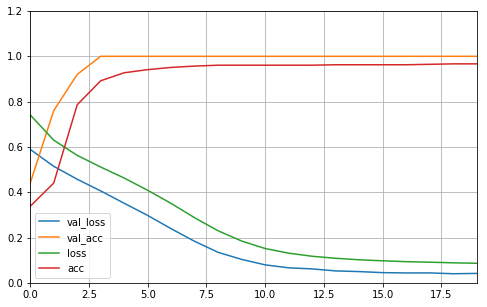

In [15]:
best_nn_history = best_nn.history
pd.DataFrame(best_nn_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # set the vertical range to [0-1]
plt.show()

# SVM

In [40]:
from sklearn.svm import SVC

In [41]:
"Searching in the poly kernel space"
# use a full grid over all parameters
param_grid = {"degree": range(1, 10, 2),
              "coef0": [0.001, 0.01, 0.01, 1, 10, 100, 1000],
              "C": [0.001, 0.01, 0.01, 1, 10, 100, 1000]
             }

svm = SVC(kernel="poly", gamma='auto')
# run grid search
svm_grid_search = GridSearchCV(svm, 
                               param_grid=param_grid, 
                               cv=5, 
                               iid=False, 
                               return_train_score=True)
start = time()
svm_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(svm_grid_search.cv_results_['params'])))
report(svm_grid_search.cv_results_)

GridSearchCV took 75.93 seconds for 245 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 0.001, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 0.01, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 0.01, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 1, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 10, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 100, 'degree': 1}

Model with rank: 1
Mean validation score: 0.968 (std: 0.015)
Parameters: {'C': 1, 'coef0': 1000, 'degree': 1}



In [43]:
best_poly_svm = svm_grid_search.best_estimator_

Ypr = best_poly_svm.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  96.42857142857143


In [19]:
"Searching in the rbf kernel space"
# use a full grid over all parameters
param_grid = {"gamma": range(1, 10, 1),
              "coef0": [0.001, 0.01, 0.01, 1, 10, 100, 1000],
              "C": [0.001, 0.01, 0.01, 1, 10, 100, 1000]
             }

svm = SVC(kernel="rbf")
# run grid search
svm_rbf_grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, iid=False, return_train_score=True)
start = time()
svm_rbf_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(svm_rbf_grid_search.cv_results_['params'])))
report(svm_rbf_grid_search.cv_results_)

GridSearchCV took 23.11 seconds for 441 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 0.001, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 0.01, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 0.01, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 1, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 10, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 100, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 10, 'coef0': 1000, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.952 (std: 0.027)
Parameters: {'C': 100, 'coef0': 0.001, 'gamma': 1}

Model with rank: 1
Mean validation score: 0.9

In [20]:
best_rbf_svm = svm_rbf_grid_search.best_estimator_
Ypr = best_rbf_svm.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  96.42857142857143


# Nearest neighbors


In [21]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 25),
              "weights": ['uniform', "distance"],
              "p": [1, 2, 3]
             }

knn = KNeighborsClassifier()
# run grid search
knn_grid_search = GridSearchCV(knn, 
                           param_grid=param_grid, 
                           cv=5, 
                           iid=False, 
                           return_train_score=True)
start = time()
knn_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(knn_grid_search.cv_results_['params'])))
report(knn_grid_search.cv_results_)

GridSearchCV took 18.58 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.979 (std: 0.009)
Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.979 (std: 0.009)
Parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.977 (std: 0.009)
Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}



In [22]:
best_knn = knn_grid_search.best_estimator_
Ypr = best_knn.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

Accuracy is  93.57142857142857


# Boosting 

In [23]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {,
             }

bdt = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None)
# run grid search
bdt_grid_search = GridSearchCV(bdt, 
                           param_grid=param_grid, 
                           cv=5, 
                           iid=False, 
                           return_train_score=True)
start = time()
bdt_grid_search.fit(Xtr, Ytr.flat)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(knn_grid_search.cv_results_['params'])))
report(bdt_grid_search.cv_results_)

GridSearchCV took 39.09 seconds for 144 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.966 (std: 0.010)
Parameters: {'learning_rate': 0.1, 'n_estimators': 70}

Model with rank: 2
Mean validation score: 0.964 (std: 0.013)
Parameters: {'learning_rate': 1.0, 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.964 (std: 0.013)
Parameters: {'learning_rate': 0.1, 'n_estimators': 120}



In [16]:
best_bdt = bdt_grid_search.best_estimator_
Ypr = best_bdt.predict(Xts)

print("Accuracy is ", accuracy_score(Yts,Ypr)*100) 

NameError: name 'bdt_grid_search' is not defined

In [45]:
best_nn_estimator = rnd_search_cv.best_estimator_
estimators =[('decision_tree', best_dec_tree),
             #('neural_network', best_nn_estimator.model), 
             ('k-nearest-neighbor', best_knn), 
             ('SVM', best_poly_svm),
             ('ada-boost-classifier', best_bdt),
            ]


In [46]:


# save the classifier
for model_name, estimator in estimators:
    
    file_name = MODEL_DIR + DATASET_NAME + "-" + model_name + ".pkl"
    print(file_name)
    
    with open(file_name, 'wb') as fid:
        pickle.dump(estimator, fid)


models/breast_cancer-SVM.pkl


In [7]:
import pickle

MODEL_DIR ="models/"
DATASET_NAME = "breast_cancer"

# loading the classifier
estimators =[('decision_tree', 0),
             #('neural_network', best_nn_estimator.model), 
             ('k-nearest-neighbor', 0), 
             ('SVM', 0),
             ('ada-boost-classifier', 0),
            ]
models = []

for model_name, estimator in estimators:
    
    file_name = MODEL_DIR + DATASET_NAME + "-" + model_name + ".pkl"
    print(file_name)
    
    with open(file_name, 'rb') as fid:
        model_loaded = pickle.load(fid)
    
    Ypr = model_loaded.predict(Xts)
    print(model_name, accuracy_score(Yts,Ypr)*100) 
    models.append((model_name, model_loaded))

models/breast_cancer-decision_tree.pkl
decision_tree 95.0
models/breast_cancer-k-nearest-neighbor.pkl
k-nearest-neighbor 93.57142857142857
models/breast_cancer-SVM.pkl
SVM 96.42857142857143
models/breast_cancer-ada-boost-classifier.pkl
ada-boost-classifier 94.28571428571428


In [8]:
from keras.models import model_from_json
from tensorflow import keras
from keras.initializers import glorot_uniform
from keras.utils import CustomObjectScope

def save_neural_network_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    model_name = MODEL_DIR + DATASET_NAME + "-" + name
    with open(model_name + "-model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + "-weights.h5")
    history = model.history.history
    with open(model_name + "-history", 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
def load_neural_network(model_name):
    model_name = "neural_network"
    with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        json_file = open(MODEL_DIR + DATASET_NAME + "-" + model_name + "-model.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(MODEL_DIR + DATASET_NAME + "-" + model_name + "-weights.h5")
        print("Loaded model from disk")

    #Load history
    with open(MODEL_DIR + DATASET_NAME + "-" + model_name + "-history", 'rb') as fid:
        loaded_history = pickle.load(fid)
        
    return loaded_model, loaded_history

Using TensorFlow backend.


In [26]:
save_neural_network_model(best_nn_estimator.model, "neural_network")

NameError: name 'best_nn_estimator' is not defined

In [10]:
nn, his = load_neural_network("neural_network")
nn_history = his
models.append(("neural_network", nn))

Loaded model from disk


In [11]:
Ypr = nn.predict(Xts)
Ypr = (Ypr > 0.5)
print("neural_network", accuracy_score(Yts,Ypr)*100)

InternalError: Blas GEMM launch failed : a.shape=(32, 9), b.shape=(9, 6), m=32, n=6, k=9
	 [[{{node dense_135_1/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_135_input_1_0_0/_97, dense_135_1/kernel/read)]]
	 [[{{node dense_138_1/Sigmoid/_99}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_41_dense_138_1/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]